In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import MinMaxScaler
import joblib

import matplotlib.pyplot as plt
%matplotlib inline

In [153]:
class synthesis_scheme():
    
    def _init_(self):
        m1 = 0
        v1 = 0
        c1 = 0
        m2 = 0
        v2 = 0
        c2 = 0
        vsolv = 0
        csolv = 0
        mad = 0
        cad = 0
        heat = 0
        autoclave = 0
        ph = 0
        r1 = 'None'
        r2 = 'None'
        solvent = 'None'
        add_to_solvent = 'None'
        return
    
    def __str__(self):
        out = 'R1: ' + str(self.r1) + '\n' + \
            'M1: ' + str(self.m1) + '\n' + \
            'V1: ' + str(self.v1) + '\n' + \
            'C1: ' + str(self.c1) + '\n' + \
            'R2: ' + self.r2 + '\n' + \
            'M2: ' + str(self.m2) + '\n' + \
            'V2: ' + str(self.v2) + '\n' + \
            'C2: ' + str(self.c2) + '\n' + \
            'Solvent: ' + self.solvent + '\n' + \
            'V solvent: ' + str(self.vsolv) + '\n' + \
            'C solvent: ' + str(self.csolv) + '\n' + \
            'Add to solvent: ' + self.add_to_solvent + '\n' + \
            'Mad: ' + str(self.mad) + '\n' + \
            'Cad: ' + str(self.cad) + '\n' + \
            'Heat: ' + str(self.heat) + '\n' + \
            'Autoclave: ' + str(int(self.autoclave)) + '\n' + \
            'pH adjustment: ' + str(self.ph) + '\n'
            
        return out
                

In [172]:
class nanozymes_synthesis():
    
    def _init_(self):
        return
        
    
    def load(self,
             sourse_data, #='nanozymes.xlsx',
             target_data, #='nanozymes_add.xlsx',
             voc_formulas, #='nanozymes_formulas.xlsx',
             voc_reactions, #='reaction_types.xlsx',
             voc_reagents #='Rs.xlsx'
            ):
        
        self.df_main = pd.read_excel(sourse_data, index_col=0)
        self.df_rtypes = pd.read_excel(voc_reactions, index_col=0)
        self.df_formulas = pd.read_excel(voc_formulas, index_col=0)
        self.df_add = pd.read_excel(target_data)
        self.df_rs = pd.read_excel(voc_reagents, index_col=None)
        
        return
        
        
    def _prepare_main(self, df):
    
        df['Syngony'].fillna(0, inplace=True)
        df['length, nm'].fillna(0, inplace=True)
        df['width, nm'].fillna(0, inplace=True)
        df['depth, nm'].fillna(0, inplace=True)
        df['pol'].fillna(0, inplace=True)
        df['Mw(coat), g/mol'].fillna(0, inplace=True)
        df['C min, mM'].fillna(0, inplace=True)
        df['C max, mM'].fillna(0, inplace=True)
        df['C(const), mM'].fillna(0, inplace=True)
        df['Ccat(mg/mL)'].fillna(0, inplace=True)
        df['ph'].fillna(0, inplace=True)
        df['temp, °C'].fillna(0, inplace=True)
    
        df['Km, mM'] = pd.to_numeric(df['Km, mM'], errors='coerce')
        df['Vmax, mM/s'] = pd.to_numeric(df['Vmax, mM/s'], errors='coerce')
        df['C(const), mM'] = pd.to_numeric(df['C(const), mM'], errors='coerce')
    
        df['Km, mM'].fillna(0, inplace=True)
        df['Vmax, mM/s'].fillna(0, inplace=True)
        df['C(const), mM'].fillna(0, inplace=True)
    
        return df
    
    def preprocessing(self):
        
        self._prepare_main(self.df_main)
        self.build_merged_data()
        
        return
        
    def build_merged_data(self):
        
        df_main_merged = self.df_main.merge(self.df_rtypes, left_on='ReactionType', right_on='formula', how='left')
        df_main_merged = df_main_merged.merge(self.df_formulas, left_on='formula', right_on='formula', how='left')
        df_main_merged = df_main_merged.drop(columns=['formula', 'link','ReactionType','dec_ord_x', 'dec_ord_y', 'r_all', 'formula_all'])
        df_merged = self.df_add.merge(self.df_rs, left_on='R1', right_on='formula', how='left', suffixes=(None,'_r1'))
        df_merged = df_merged.merge(self.df_rs, left_on='R2', right_on='formula', how='left', suffixes=(None,'_r2'))
        df_merged = df_merged.merge(self.df_rs, left_on='solvent', right_on='formula', how='left', suffixes=(None,'_solvent'))
        df_merged = df_merged.merge(self.df_rs, left_on='add to solvent', right_on='formula', how='left', suffixes=(None,'_add_to_solvent'))
        df_merged.set_index('Индекс', inplace=True)
        df_merged = df_merged.drop(columns=['Формула', 'Ссылка на статью','R1','R2', 'solvent', 'add to solvent',
                                            'formula', 'dec_ord', 'r_all', 'formula_r2', 'dec_ord_r2', 'r_all_r2',
                                            'formula_solvent', 'dec_ord_solvent','r_all_solvent',
                                            'formula_add_to_solvent','dec_ord_add_to_solvent','r_all_add_to_solvent',
                                            #'Индекс'
                                           ])
        df_all = df_main_merged.merge(df_merged, left_index=True, right_index=True, how='inner')
        
        self.df_dummies = pd.get_dummies(df_all)

        self.columns_source = [
                           'Syngony', 'length, nm', 'width, nm', 'depth, nm',
                           'Mw(coat), g/mol', 'Km, mM', 'Vmax, mM/s', 'C min, mM',
                           'C max, mM', 'C(const), mM', 'Ccat(mg/mL)', 'ph', 'temp, °C',
                           'rtype_0', 'rtype_1', 'rtype_2', 'rtype_3', 'rtype_4', 'rtype_5',
                           'formula_0', 'formula_1', 'formula_2', 'formula_3', 'formula_4',
                           'formula_5', 'formula_6', 'formula_7', 'formula_8',
                           'activity_oxidase', 'activity_peroxidase',
                           'surface_chitosan', 'surface_naked',
                           'surface_poly(ethylene oxide)', 'pol_0',
                           'pol_poly(N-Vinylpyrrolidone)', 'pol_poly(N-Vinylpyrrolidone) ',
                           'pol_poly(ethylene oxide)', 'pol_therabloat', 'surf_0',
                           'surf_Glutathione', 'surf_citric acid', 'surf_ethylene glycol'
                         ]
        self.columns_target = ['M1, mg',
                          'V1, mL', 'С1, M', 'M2, g', 'V2, mL', 'С2, M', 'Vsolv, мл',
                          'Csolv, M', 'Mad, g', 'Сad, моль/л', 'heat', 'autoclave',
                          'pH adjustment', 'r_0', 'r_1', 'r_2', 'r_3', 'r_4', 'r_5', 'r_6',
                          'r_0_r2', 'r_1_r2', 'r_2_r2', 'r_3_r2', 'r_4_r2', 'r_5_r2',
                          'r_6_r2', 'r_0_solvent', 'r_1_solvent', 'r_2_solvent',
                          'r_3_solvent', 'r_4_solvent', 'r_5_solvent', 'r_6_solvent',
                          'r_0_add_to_solvent', 'r_1_add_to_solvent', 'r_2_add_to_solvent',
                          'r_3_add_to_solvent', 'r_4_add_to_solvent', 'r_5_add_to_solvent',
                          'r_6_add_to_solvent',
                         ]
               
        return

    def model_linear(self, inp_len, out_len):

        input = Input(inp_len)
        inner_1 = Dense(inp_len*2)(input)
        inner_1 = Activation('gelu')(inner_1)
        inner_2 = Dense(inp_len*2)(inner_1)
        inner_2 = Activation('gelu')(inner_2)
        inner_3 = Dense(inp_len*2)(inner_2)
        inner_3 = Activation('gelu')(inner_3)        
        out = Dense(out_len)(inner_3)
        out = Activation('relu')(out)

        model = Model(input, out)
        model.summary()

        return model    

    def plot_history(self):
        
        plt.plot(self.history.history['loss'], label='train loss')
        plt.plot(self.history.history['val_loss'], label='val loss')
        plt.legend()
        plt.show()
        
        return
    
    def train(self, epochs):
        
        inp_len = len(self.columns_source)
        out_len = len(self.columns_target)
        
        df_input = self.df_dummies[self.columns_source].to_numpy()
        df_target = self.df_dummies[self.columns_target].to_numpy()
        
        X_train, X_test, Y_train, Y_test = train_test_split(df_input, df_target,
                                                    test_size=0.2, random_state=42)
        self.X_train = X_train
        
        X_scaler = MinMaxScaler()
        Y_scaler = MinMaxScaler()

        X_train_scaled = X_scaler.fit_transform(X_train)
        Y_train_scaled = Y_scaler.fit_transform(Y_train)

        X_test_scaled = X_scaler.transform(X_test)
        Y_test_scaled = Y_scaler.transform(Y_test)

        #X_train_scaled = X_train
        #Y_train_scaled = Y_train

        #X_test_scaled = X_test
        #Y_test_scaled = Y_test
        
        
        joblib.dump(X_scaler, 'x_scaler')
        joblib.dump(Y_scaler, 'y_scaler')

        self.model = self.model_linear(inp_len, out_len)
        self.model.compile(optimizer=Adamax(learning_rate=1e-4), loss='mae')
        self.history = self.model.fit(X_train_scaled, Y_train_scaled,
                                       epochs=epochs,
                                       validation_data=(X_test_scaled, Y_test_scaled),
                                       batch_size=1)
        
        
        return self.history
    
    def predict(self, data):
        
        out = self.model.predict(data)[0]
        self.out = out
        
        res = synthesis_scheme()        
        res.m1 = out[0]
        res.v1 = out[1]
        res.c1 = out[2]
        res.m2 = out[3]
        res.v2 = out[4]
        res.c2 = out[5]
        res.vsolv = out[6]
        res.csolv = out[7]
        res.mad = out[8]
        res.cad = out[9]
        res.heat = out[10]
        res.autoclave = out[11]
        res.ph = out[12]
        res.r1 = self._get_rname(out[13:19])
        res.r2 = self._get_rname(out[20:26])
        res.solvent = self._get_rname(out[27:33])
        res.add_to_solvent = self._get_rname(out[34:40])
               
        return res
    
    def _get_rname(self, data_bin):
        
        data_bin[data_bin>=0.5] = 1
        data_bin[data_bin<0.5] = 0
        data_bin = data_bin.astype(int)
        data_bin = ''.join(data_bin.astype(str))
        res = self.df_rs[self.df_rs.r_all == int(data_bin)].to_numpy()
        res = 'None' if res.shape[0]==0 else res[0,0]
        return res

    def _get_nanozymesmname(self, data_bin):
        
        data_bin[data_bin>=0.5] = 1
        data_bin[data_bin<0.5] = 0
        data_bin = data_bin.astype(int)
        data_bin = ''.join(data_bin.astype(str))
        res = self.df_formulas[self.df_formulas.r_all == int(data_bin)].to_numpy()
        res = 'None' if res.shape[0]==0 else res[0,0]
        return res

    def _get_rtypesname(self, data_bin):
        
        data_bin[data_bin>=0.5] = 1
        data_bin[data_bin<0.5] = 0
        data_bin = data_bin.astype(int)
        data_bin = ''.join(data_bin.astype(str))
        res = self.df_rtypes[self.df_rtypes.r_all == int(data_bin)].to_numpy()
        res = 'None' if res.shape[0]==0 else res[0,0]
        return res
    
    
    def save_model(self, filename):
        
        save_model(filename)
        
        return
    
    def load_model(self, filename):
        
        model = load_model(filename)
        
        return
    
            



In [173]:
ns = nanozymes_synthesis()
ns.load('nanozymes.xlsx',
        'nanozymes_add.xlsx',
        'nanozymes_formulas.xlsx',
        'reaction_types.xlsx',
        'Rs.xlsx'
       )
ns.preprocessing()
ns.train(50)


Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 42)]              0         
                                                                 
 dense_83 (Dense)            (None, 84)                3612      
                                                                 
 activation_73 (Activation)  (None, 84)                0         
                                                                 
 dense_84 (Dense)            (None, 84)                7140      
                                                                 
 activation_74 (Activation)  (None, 84)                0         
                                                                 
 dense_85 (Dense)            (None, 84)                7140      
                                                                 
 activation_75 (Activation)  (None, 84)                0  

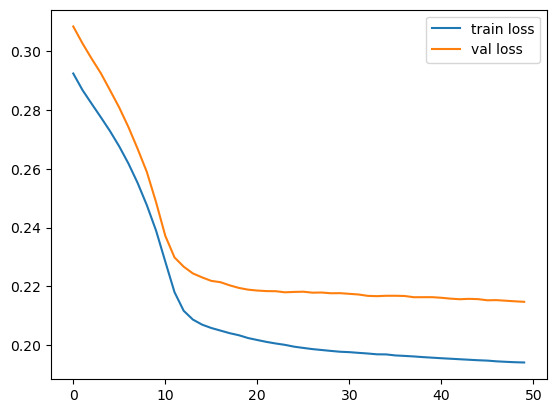

In [174]:
ns.plot_history()

In [95]:
a = ns.X_train
a.shape

(91, 42)

In [175]:
test = np.array([[7.000e+00, 9.000e+01, 9.000e+01, 5.000e+00, 2.900e+04, 3.193e+02,
       6.794e-02, 1.000e-03, 2.000e+03, 2.000e-01, 2.000e-03, 3.000e+00,
       4.000e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
       1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
       0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]])
res = ns.predict(test)
print (res)

1/1 [==============================] - 0s 150ms/step
R1: H2O2
M1: 618.3894
V1: 1247.2554
C1: 1497.9309
R2: W(C2H5O)6
M2: 0.0
V2: 701.139
C2: 0.0
Solvent: NH4Ac
V solvent: 0.0
C solvent: 0.0
Add to solvent: NH4VO3
Mad: 672.56433
Cad: 0.0
Heat: 705.86115
Autoclave: 0
pH adjustment: 1977.5671



In [169]:
ns.out

array([2.2860256e+03, 0.0000000e+00, 0.0000000e+00, 3.1578933e+03,
       4.8382828e+02, 1.0353296e+03, 1.0482001e+03, 0.0000000e+00,
       5.0662155e+02, 0.0000000e+00, 0.0000000e+00, 8.6405682e+02,
       0.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 0.0000000e+00, 1.2001923e+03,
       1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00,
       0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 1.0000000e+00, 1.0000000e+00, 0.0000000e+00,
       1.0000000e+00, 1.0588315e+03, 1.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 0.0000000e+00, 1.0000000e+00, 1.0000000e+00,
       1.5549937e+03], dtype=float32)

In [128]:
ns.df_rs

,formula,dec_ord,r_all,r_0,r_1,r_2,r_3,r_4,r_5,r_6
0,ZnSO4,1,1,0,0,0,0,0,0,1
1,Cu(NO3)2,2,10,0,0,0,0,0,1,0
2,FeCl3*6H2O,3,11,0,0,0,0,0,1,1
3,Co(NO3)2*6H2O,4,100,0,0,0,0,1,0,0
4,Fe(NO3)3*9H2O,5,101,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...
74,PVP,75,1001011,1,0,0,1,0,1,1
75,HMTA,76,1001100,1,0,0,1,1,0,0
76,L-arginine,77,1001101,1,0,0,1,1,0,1
77,TCPP,78,1001110,1,0,0,1,1,1,0


In [ ]:
self.df_rtypes[self.df_rtypes.r_all == int(data_bin)].to_numpy()